In [1]:
#from IFD_tsne import *
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps

from tsne_jax import *

from utils import MidpointNormalize, load_data
import matplotlib.pyplot as plt
import tikzplotlib

from tueplots import cycler, fonts, fontsizes, bundles
from tueplots.constants import markers
from tueplots.constants.color import palettes

plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
plt.rcParams.update(fonts.aistats2022_tex(family="serif"))
plt.rcParams.update(fontsizes.aistats2022())
plt.rcParams['axes.grid'] = False


In [2]:
#X, y = make_blobs(n_samples=50, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
X, y = load_data(50)
key = random.PRNGKey(41)
#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

I0000 00:00:1718197945.721222       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.8811, 50 iterations in 0.3043 sec
Iteration  100, KL divergence 0.8275, 50 iterations in 0.3054 sec
Iteration  150, KL divergence 0.9767, 50 iterations in 0.2885 sec
Iteration  200, KL divergence 1.0049, 50 iterations in 0.2787 sec
Iteration  250, KL divergence 0.8934, 50 iterations in 0.3063 sec
   --> Time elapsed: 1.48 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.1740, 50 iterations in 0.3318 sec
Iteration  100, KL divergence 0.1740, 50 iterations in 0.3114 sec
Iteration  150, KL divergence 0.1740, 50 iterations in 0.2668 sec
Iteration  200, KL divergence 0.1740, 50 iterations in 0.2660 sec
Iteration 

In [4]:
f = partial(KL_divergence_dy, X_unflattener=X_unflattener, Y_unflattener=Y_unflattener, perplexity=30.0)
H = jax.jacrev(f, argnums=1)(X_flat, Y_flat)

In [7]:
fun = lambda y: KL_divergence(X_flat, y, X_unflattener, Y_unflattener)
H = jax.hessian(fun)(Y_flat)

Computing pairwise distances...
Starting binary search
Entered binary search function


In [5]:
u, s, w = np.linalg.svd(H)

In [31]:
print(KL_divergence(X_flat, u[:, 97] + u[:, 98] + u[:, 99] + Y_flat, X_unflattener, Y_unflattener))
print(KL_divergence(X_flat, u[:, 97] + 3*u[:, 98] + 10*u[:, 99] + Y_flat, X_unflattener, Y_unflattener))

Computing pairwise distances...
Starting binary search
Entered binary search function
0.15162385
Computing pairwise distances...
Starting binary search
Entered binary search function
0.15162417


Text(0.5, 0, 'singular values')

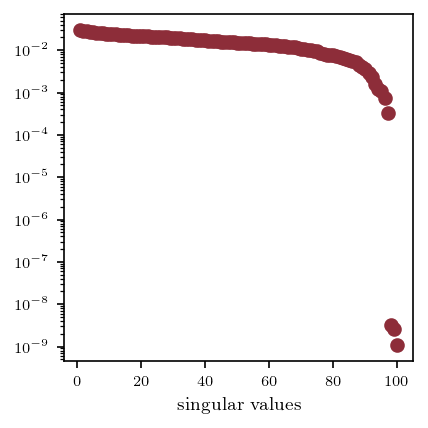

In [6]:
f, ax1 = plt.subplots(1, 1, figsize=(3, 3))
ax1.scatter([i for i in range(1, len(s)+1)], np.flip(np.sort(np.abs(s))))
ax1.set_yscale('log')
ax1.set_xlabel('singular values')
#tikzplotlib.save("figures_diss/singular_values.pgf")

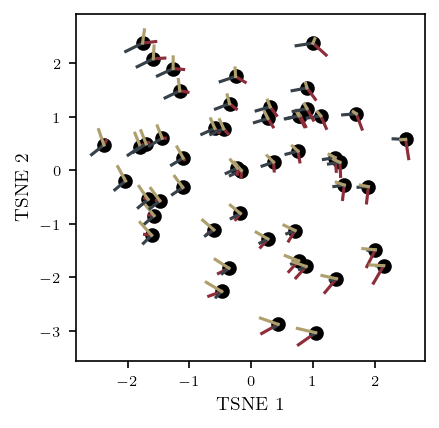

In [7]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(*Y_star.T, c='black')
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
for i, j in enumerate(Y_star):
  vector = Y_unflattener(u[:, 97])*1.5
  ax.plot([j[0], (j+vector[i])[0]] , [j[1], (j+vector[i])[1]], color = palettes.tue_plot[0])
  vector = Y_unflattener(u[:, 98])*1.5
  ax.plot([j[0], (j+vector[i])[0]] , [j[1], (j+vector[i])[1]], color = palettes.tue_plot[1])
  vector = Y_unflattener(u[:, 99])*1.5
  ax.plot([j[0], (j+vector[i])[0]] , [j[1], (j+vector[i])[1]], color = palettes.tue_plot[2])
#tikzplotlib.save("figures_diss/singular_vectors.pgf")

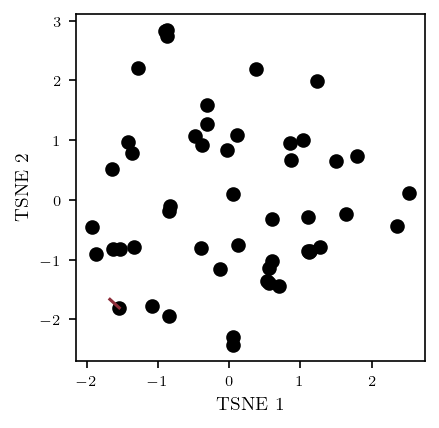

In [22]:
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(*Y_star.T, c='black')
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
j = Y_star[0]
vector = Y_unflattener(u[:, 97])
ax.plot([j[0], (j+vector[0])[0]] , [j[1], (j+vector[0])[1]], color = palettes.tue_plot[0])
#vector = Y_unflattener(u[:, 98])
#ax.arrow(j[0], j[1], vector[i, 0], vector[i, 1], color = palettes.tue_plot[1])
#vector = Y_unflattener(u[:, 99])
#ax.arrow(j[0], j[1], vector[i, 0], vector[i, 1], color = palettes.tue_plot[2])
#tikzplotlib.save("figures_diss/singular_vectors.pgf")

In [14]:
from scipy.optimize import fmin
import numpy as np

y_range = np.linspace(-1, 1, 100)
zs = []
cs = []

def loss(x, y):
  alpha = np.deg2rad(15)
  return ((4 - 2.1*(np.sin(alpha)*x + np.cos(alpha)*y)**2 + (np.sin(alpha)*x + np.cos(alpha)*y)**4/3)*(np.sin(alpha)*x + np.cos(alpha)*y)**2 + (np.sin(alpha)*x + np.cos(alpha)*y)*(np.cos(alpha)*x - np.sin(alpha)*y)+(-4 + 4*(np.cos(alpha)*x - np.sin(alpha)*y)**2)*(np.cos(alpha)*x - np.sin(alpha)*y)**2)

for y_test in y_range:
  fun = lambda z: loss(y_test, z)
  z = fmin(fun, 0.0)[0]
  print(z)
  zs.append(z)
  cs.append(loss(y_test, z))

Optimization terminated successfully.
         Current function value: 0.199291
         Iterations: 19
         Function evaluations: 38
0.11643750000000008
Optimization terminated successfully.
         Current function value: 0.038742
         Iterations: 19
         Function evaluations: 38
0.13181250000000008
Optimization terminated successfully.
         Current function value: -0.108916
         Iterations: 19
         Function evaluations: 38
0.1463750000000001
Optimization terminated successfully.
         Current function value: -0.244007
         Iterations: 20
         Function evaluations: 40
0.16000000000000011
Optimization terminated successfully.
         Current function value: -0.366874
         Iterations: 20
         Function evaluations: 40
0.17281250000000012
Optimization terminated successfully.
         Current function value: -0.477880
         Iterations: 20
         Function evaluations: 40
0.18487500000000012
Optimization terminated successfully.
         Cu

In [17]:
for ys in [-0.001, 0.0, 0.001]:
  fun = lambda z: loss(ys, z)
  print(fmin(fun, 0.0)[0])

Optimization terminated successfully.
         Current function value: -0.000005
         Iterations: 5
         Function evaluations: 10
0.00075
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
0.0
Optimization terminated successfully.
         Current function value: -0.000005
         Iterations: 6
         Function evaluations: 12
-0.00075


In [19]:
0.00075/0.001

0.75

In [8]:
coordinates = np.vstack([y_range, zs, cs]).T

In [9]:
for i in coordinates:
  print('(', i[0],',', i[1],',', i[2], ')')

( -1.0 , 0.11643750000000008 , 0.19929058690133655 )
( -0.9797979797979798 , 0.13181250000000008 , 0.038741645369799516 )
( -0.9595959595959596 , 0.1463750000000001 , -0.1089163601216957 )
( -0.9393939393939394 , 0.16000000000000011 , -0.24400702940268687 )
( -0.9191919191919192 , 0.17281250000000012 , -0.3668744129004933 )
( -0.898989898989899 , 0.18487500000000012 , -0.4778798594469174 )
( -0.8787878787878788 , 0.19612500000000016 , -0.5773993686159185 )
( -0.8585858585858586 , 0.20668750000000016 , -0.6658213986991623 )
( -0.8383838383838383 , 0.21650000000000016 , -0.7435450058555371 )
( -0.8181818181818181 , 0.22556250000000017 , -0.8109782855733767 )
( -0.797979797979798 , 0.2339375000000002 , -0.8685370171868662 )
( -0.7777777777777778 , 0.2416250000000002 , -0.9166435441884002 )
( -0.7575757575757576 , 0.24856250000000019 , -0.9557258039799451 )
( -0.7373737373737373 , 0.2548125000000002 , -0.9862164639502419 )
( -0.7171717171717171 , 0.2603125000000003 , -1.008552234487507 )
(

In [10]:
for i in coordinates:
  print('(', i[0],',', i[1],',', 6, ')')

( -1.0 , 0.11643750000000008 , 6 )
( -0.9797979797979798 , 0.13181250000000008 , 6 )
( -0.9595959595959596 , 0.1463750000000001 , 6 )
( -0.9393939393939394 , 0.16000000000000011 , 6 )
( -0.9191919191919192 , 0.17281250000000012 , 6 )
( -0.898989898989899 , 0.18487500000000012 , 6 )
( -0.8787878787878788 , 0.19612500000000016 , 6 )
( -0.8585858585858586 , 0.20668750000000016 , 6 )
( -0.8383838383838383 , 0.21650000000000016 , 6 )
( -0.8181818181818181 , 0.22556250000000017 , 6 )
( -0.797979797979798 , 0.2339375000000002 , 6 )
( -0.7777777777777778 , 0.2416250000000002 , 6 )
( -0.7575757575757576 , 0.24856250000000019 , 6 )
( -0.7373737373737373 , 0.2548125000000002 , 6 )
( -0.7171717171717171 , 0.2603125000000003 , 6 )
( -0.696969696969697 , 0.2651250000000003 , 6 )
( -0.6767676767676767 , 0.26918750000000025 , 6 )
( -0.6565656565656566 , 0.27256250000000026 , 6 )
( -0.6363636363636364 , 0.2751250000000003 , 6 )
( -0.6161616161616161 , 0.27700000000000025 , 6 )
( -0.5959595959595959 , 0

In [10]:
import numpy as np

def f(x, y):
    return (4 - 2.1*(np.sin(15)*x + np.cos(15)*y)**2 + (np.sin(15)*x + np.cos(15)*y)**4/3)*(np.sin(15)*x + np.cos(15)*y)**2 + (np.sin(15)*x + np.cos(15)*y)*(np.cos(15)*x - np.sin(15)*y)+(-4 + 4*(np.cos(15)*x - np.sin(15)*y)**2)*(np.cos(15)*x - np.sin(15)*y)**2

result = f(-1, -2)
print("Result:", result)


Result: 58.84808833816323


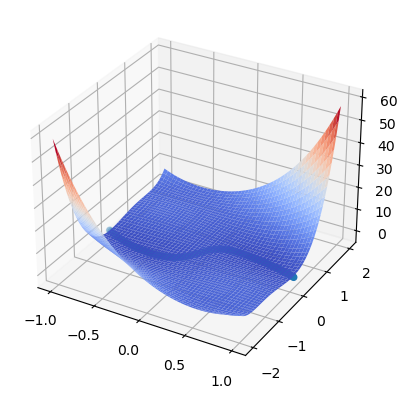

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.arange(-1, 1, 0.01)
Y = np.arange(-2, 2, 0.01)
X, Y = np.meshgrid(X, Y)
Z = f(X, Y)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0)
ax.scatter(*coordinates.T)